In [1]:
import json
from sys import stderr
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, Latex

from databinning import *
from mpc import *
from fpd import *


### Probabilistic models
Reads previously obtained probabilistic models.

In [2]:
f_x = np.load('./data/f_x.npy')
g_x = np.load('./data/g_x.npy')

### Parameters

In [3]:
# State dimension
x_dim = 2

# Input dimension
u_dim = 2

# Bounds for state and input
x_min = np.zeros(x_dim)
u_min = np.zeros(u_dim)

x_max = np.array([150, 100])
u_max = np.array([35, 0.35])

# Amount of bins for state and input
x_discr = np.array([300, 200])
u_discr = np.array([70, 35])

# Discretization step for state and input
x_step = np.array((x_max - x_min)/x_discr)
u_step = np.array((u_max - u_min)/u_discr)

In [4]:
x1_axis = [x_min[0] + (i + 0.5)*x_step[0] for i in range(x_discr[0])]
x2_axis = [x_min[1] + (i + 0.5)*x_step[1] for i in range(x_discr[1])]

x_axis = np.dstack((np.meshgrid(x1_axis, x2_axis)))

u1_axis = [u_min[0] + (i + 0.5)*u_step[0] for i in range(u_discr[0])]
u2_axis = [u_min[1] + (i + 0.5)*u_step[1] for i in range(u_discr[1])]

u_axis = np.dstack((np.meshgrid(u1_axis, u2_axis)))


### Simulation parameters
Defines the total simulation time and sampling time.

In [5]:
# Total simulation time: 24h (1440m)
total_time = 1440  

# Sample time: 1m
t_step = 1

# Number of control step: total_time/t_step = 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# References
LacI_ref = 23.48
TetR_ref = 10.00

### MPC Controller
Initialises the MPC controller used for online generation of the target policy.

In [6]:
setup_mpc = {
    'n_robust': 0,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': False
}

toggle = ToggleSwitchSimplifiedModel(False, LacI_ref, TetR_ref, t_step, total_time, 240)
model = toggle.get_model()
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, False)
simulator = mpc_controller.simulator
estimator = mpc_controller.estimator
mpc = mpc_controller.controller


### Control from demonstration
Defines the main loop of the algorithm control from demonstration.

In [7]:
%%capture cap --no-stderr
episodes = 10

states = np.zeros((episodes, steps, x_dim))
inputs = np.zeros((episodes, steps, u_dim))

for i in range(episodes):

    x_0 = np.array([20.68, 2.11])
    toggleswitch = ToggleSwitchSimplified()
    toggleswitch.initialState(x_0)

    fpd = ControllerFPD(f_x, g_x, toggleswitch)

    mpc.reset_history()
    mpc.x0 = x_0

    mpc.set_initial_guess()

    for k in range(steps):

        u_target = mpc.make_step(x_0)        

        if (mpc.t0 - t_step) % 15 == 0:
            uk = fpd.makeFPDStep(u_target[:, 0], u_step, u_discr, u_axis, x_dim, x_min, x_step, x_max)
            ukm1 = uk
        else:
            uk = ukm1
              
        y_next = simulator.make_step(uk)
        x_0 = estimator.make_step(y_next)
        inputs[i, k] = uk[:,0]

    states[i] = np.array(mpc.data['_x'].tolist())


Computes the average trajectory of the state and input between episodes.

In [8]:
#u_mean = np.array([[np.mean(inputs[:, i, 0]), np.mean(inputs[:, i, 1])] for i in range(steps)])
x_mean = np.array([[np.mean(states[:, i, 0]), np.mean(states[:, i, 1])] for i in range(steps)])

data = {
    'v1' : inputs[0, :, 0].tolist(),
    'v2' : inputs[0, :, 1].tolist()
}

f = open('./data/policy.json', 'w')
data_json = json.dumps(data)
f.write(data_json)
f.close()

Computes the mean value of the state trajectory for each episode every 240 minutes.

In [9]:
avg_samples_range = int(avg_period/t_step)
avg_x = np.arange(0, total_time, avg_period)
avg_stop_time = total_time - ((total_time-1) % avg_period) - 1
avg_time = np.arange(0, avg_stop_time, t_step)

average_states = np.zeros((episodes, avg_stop_time, x_dim))

for i in range(episodes):

    x1_avg = [np.mean(states[i, x:x + avg_samples_range, 0]) for x in range(0, steps, avg_samples_range)]
    x2_avg = [np.mean(states[i, x:x + avg_samples_range, 1]) for x in range(0, steps, avg_samples_range)]

    fx1_avg = CubicSpline(avg_x, x1_avg)
    average_states[i, :, 0] = fx1_avg(avg_time)
    fx2_avg = CubicSpline(avg_x, x2_avg)
    average_states[i, :, 1] = fx2_avg(avg_time)


Computes the average trajectory of the state between all episodes.

In [10]:
mean = np.zeros((avg_stop_time, x_dim))
std = np.zeros((avg_stop_time, x_dim))

for i in range(avg_stop_time):
    mean[i] = np.array([np.mean(average_states[:, i, 0]), np.mean(average_states[:, i, 1])])
    std[i] = np.array([np.std(average_states[:, i, 0]), np.std(average_states[:, i, 1])])

### Results plot

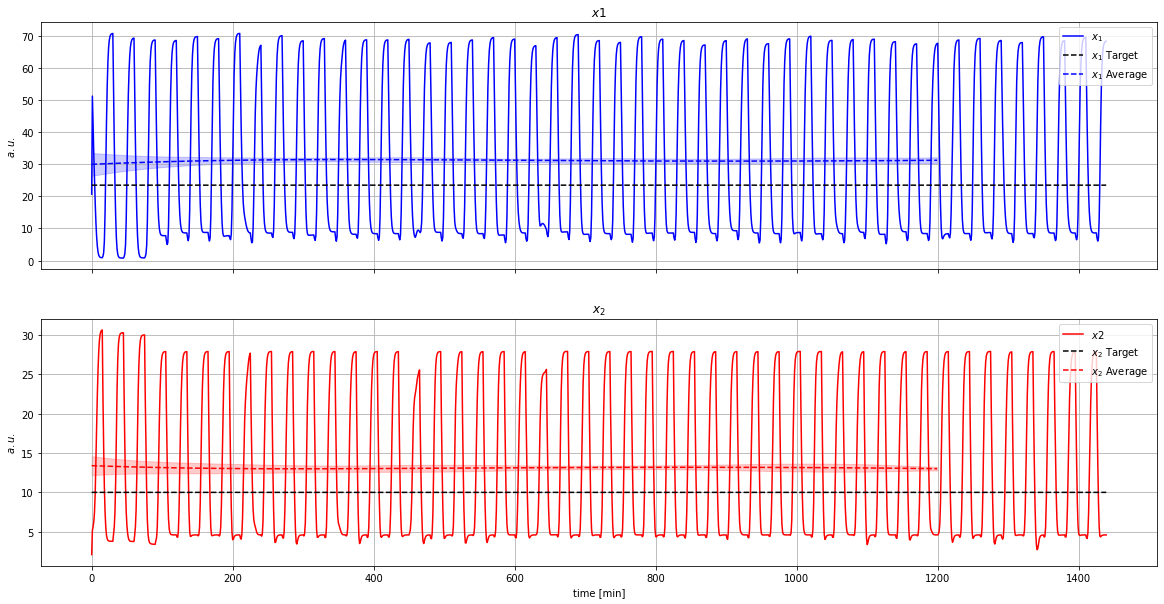

In [11]:
fig_x = 20
fig_y = 10

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14


figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

axes[0].set_ylabel(r'$a.u.$')
axes[0].set_title(r'$x1$')
line_x1, = axes[0].plot(mpc.data['_time'], x_mean[:, 0], color='b')
line_ref_x1, = axes[0].plot(mpc.data['_time'], LacI_ref*np.ones(len(mpc.data['_time'])), color='k', linestyle='--')
line_avg_x1, = axes[0].plot(avg_time, mean[:, 0], color='b', linestyle='--')
axes[0].legend([r'$x_1$', r'$x_1$ Target', r'$x_1$ Average'], loc='upper right')
axes[0].fill_between(avg_time, (mean[:, 0] - std[:, 0]), (mean[:, 0] + std[:, 0]), color='b', alpha=0.2)

axes[1].set_ylabel(r'$a.u.$')
axes[1].set_title(r'$x_2$')
line_TetR, = axes[1].plot(mpc.data['_time'], x_mean[:, 1], color='r')
line_ref_TetR, = axes[1].plot(mpc.data['_time'], TetR_ref*np.ones(len(mpc.data['_time'])), color='k', linestyle='--')
line_avg_TetR, = axes[1].plot(avg_time, mean[:, 1], color='r', linestyle='--')
axes[1].legend([r'$x2$', r'$x_2$ Target', r'$x_2$ Average'], loc='upper right')
axes[1].set_xlabel('time [min]')
axes[1].fill_between(avg_time, (mean[:, 1] - std[:, 1]), (mean[:, 1] + std[:, 1]), color='r', alpha=0.2)

figure.set_facecolor("white")
figure.savefig('./results/fdp_results.png')


In [12]:
avg_trajectories = {
    'LacI': mean[:, 0],
    'TetR': mean[:, 1]   
}

ISE, ITAE = toggle.compute_performance_metrics(avg_trajectories)


In [13]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE = "{:.2f}".format(ISE), ITAE = format(ITAE, '.2e'))

display(Markdown(metrics))

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 242.58     |
| ITAE       | 3.25e+05    |
